# Imports and Settings

In [30]:
# Standard Library Imports
import json
import math
import os
import random
import re

# Third-Party Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm

# from Imports
from colorama import Fore, Style
from haversine import haversine, Unit
from matplotlib.ticker import ScalarFormatter
from scipy.spatial import ConvexHull
from scipy.stats import circmean, circstd, gaussian_kde
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import BallTree, KernelDensity
from sklearn.preprocessing import StandardScaler

# File loading


In [2]:
columns = [
    "vehicleId", 
    "lat", 
    "lng", 
    # "dateStored", 
    "velocity",
    # "odometer", 
    # "engineVoltage", 
    "dateStoredHuman", 
    # "dateOnlyStoredHuman",    
    # "timeOnly",
    "bearing",
    "orientation", 
    "bearing_diff",
    "seconds_diff", 
    "acceleration",
    "isProblem",
    "trip_id",
    "velocity_diff",
    "distance_m"
]


input_dir   = "../../DataSets/API_Responses/Vehicle_Data/"
filename    = "all_vehicle_responses.csv"

## Enable matloblib UI backend

In [3]:
# %matplotlib tk

## Save plots & GeoJSONs files

In [4]:
PLOT_FOLDER_PATH    = "./Plots/"

GEOJSON_FOLDER_PATH = "../../DataSets/GeoJSON/"

In [5]:
"""
Reads a CSV file from the specified directory and returns a DataFrame containing only the specified columns.

Args:
    input_dir (str): Directory where the CSV file is located.
    filename (str): Name of the CSV file to read.
    columns (list): List of column names to retain in the output DataFrame.

Returns:
    pd.DataFrame: DataFrame containing only the specified columns from the CSV file.

Raises:
    FileNotFoundError: If the specified file does not exist in the given directory.
    ValueError: If an error occurs during reading or parsing the CSV file.
"""

def merge_csv_file(input_dir, filename, columns):
    input_file = os.path.join(input_dir, filename)

    if not os.path.exists(input_file):
        raise FileNotFoundError(f"File '{filename}' not found in directory '{input_dir}'")

    try:
        # Read the CSV while allowing missing columns
        df = pd.read_csv(input_file, usecols=lambda x: x.strip() in columns, encoding='utf-8')
    except Exception as e:
        raise ValueError(f"Error reading '{input_file}': {e}")

    return df



merged_dfs = merge_csv_file(input_dir, filename, columns)
print(merged_dfs.head())


   vehicleId        lat        lng  velocity      dateStoredHuman  \
0          1  37.510833  22.385710       0.0  2024-06-06 17:02:17   
1          1  37.510603  22.385977       0.0  2024-06-06 17:02:20   
2          1  37.510640  22.385927       6.0  2024-06-06 17:02:25   
3          1  37.510750  22.385907       7.0  2024-06-06 17:02:31   
4          1  37.510877  22.385698      26.0  2024-06-06 17:02:37   

   seconds_diff  trip_id  distance_m     bearing orientation  bearing_diff  \
0           0.0        0        0.00  137.402376   Southeast          0.00   
1           3.0        0       34.75  312.778670   Northwest        175.38   
2           5.0        0        6.01  351.785725       North         39.01   
3           6.0        0       12.33  307.481149   Northwest         44.30   
4           6.0        0       23.17  318.388767   Northwest         10.91   

   velocity_diff  acceleration  isProblem  
0            0.0      0.000000          0  
1            0.0      0.0000

Set **Bounding Box** only for **Τρίπολη**

# Data Overview

Text(0.5, 1.0, 'Density of problem points on spatial coordinates')

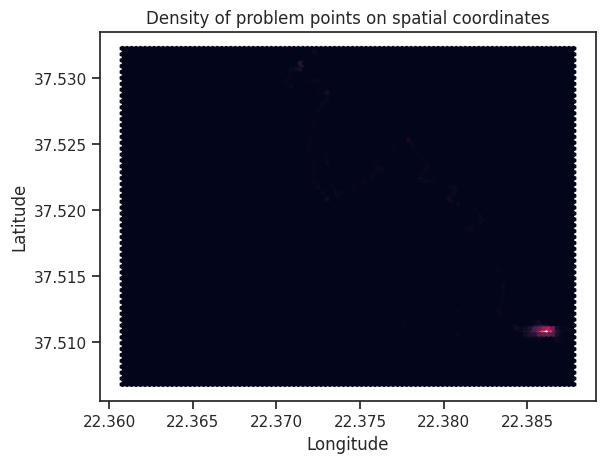

In [6]:
"""
Filters the dataset for a specific vehicle and problematic entries, then visualizes the spatial density of these points using a hexbin plot.

Steps:
    - Filters `merged_dfs` for rows where 'isProblem' equals 1.
    - Further filters to include only records for vehicleId 15.
    - Plots a hexbin density map of longitude vs. latitude for the filtered data.
    - Applies plain number formatting to axes to enhance readability.

Returns:
    None. Displays a matplotlib plot showing spatial density of problematic points.
"""

df = merged_dfs
df_danger = df[df['isProblem'] == 1]
df_danger = df[df['vehicleId'] == 15]


sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#sns.jointplot(x=df_danger['lng'], y=df_danger['lat'], kind="hex", color="#4CB391", ax=ax)
ax.hexbin(x=df_danger['lng'], y=df_danger['lat'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')  # Disable scientific notation


ax.set_title('Density of problem points on spatial coordinates')

In [7]:
# df_danger[['lng', 'lat']].describe()

# Clustering

In [8]:
# #### MOCK DATA #####
#
# data = {
#     'lng': np.random.uniform(-180, 180, 200),
#     'lat': np.random.uniform(-90, 90, 200)
# }
# df = pd.DataFrame(data)
# df_danger = df

/tmp/ipykernel_64048/2614305709.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


Plot saved to ./Plots/


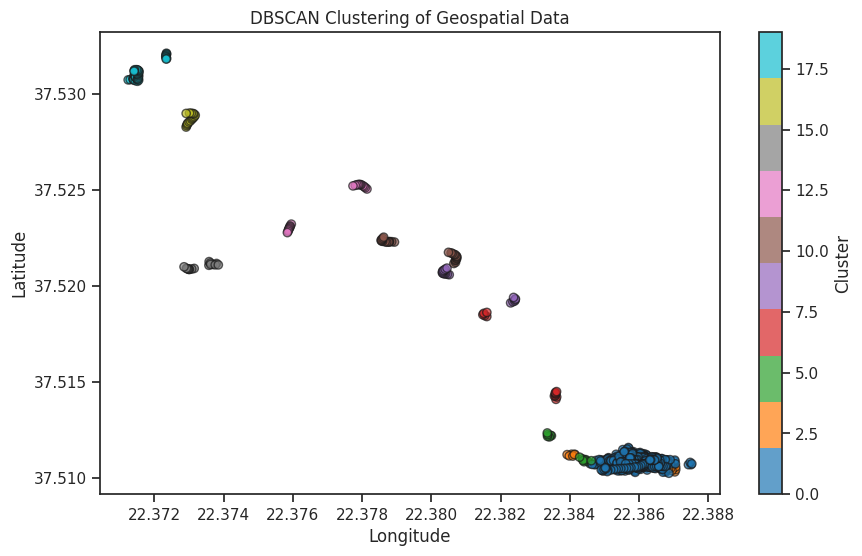

In [9]:
"""
Performs DBSCAN clustering on spatial coordinates of problematic data points and visualizes the resulting clusters.

Steps:
    - Extracts 'lng' and 'lat' columns from `df_danger`.
    - Standardizes the coordinates for improved clustering performance.
    - Applies the DBSCAN algorithm with specified `eps` and `min_samples` parameters.
    - Filters out noise points (cluster = -1) and retains only valid clusters.
    - Plots the clustered points with distinct colors and saves the figure to `PLOT_FOLDER_PATH`.

Returns:
    None. Displays and saves a scatter plot of geospatial clusters.
"""

# Extracting the coordinates
coords = df_danger[['lng', 'lat']].values

# Standardizing the data for better clustering performance
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Applying DBSCAN
dbscan = DBSCAN(eps=0.02, min_samples=4)  # Adjust eps as needed
clusters = dbscan.fit_predict(coords_scaled)

df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


df_danger_cluster = df_danger[df_danger['cluster'] > -1]


# %matplotlib inline
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(df_danger_cluster['lng'], df_danger_cluster['lat'], c=df_danger_cluster['cluster'], cmap='tab10', edgecolors='k', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Geospatial Data')
plt.colorbar(label='Cluster')

# Save the plot
# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "DBSCAN_Clustering_of_Geospatial_Data.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


In [10]:
df_danger.columns

Index(['vehicleId', 'lat', 'lng', 'velocity', 'dateStoredHuman',
       'seconds_diff', 'trip_id', 'distance_m', 'bearing', 'orientation',
       'bearing_diff', 'velocity_diff', 'acceleration', 'isProblem',
       'cluster'],
      dtype='object')

In [11]:
df_danger.describe()

,vehicleId,lat,lng,velocity,seconds_diff,trip_id,distance_m,bearing,bearing_diff,velocity_diff,acceleration,isProblem,cluster
count,1517.0,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000
mean,15.0,37.514896,22.382625,19.600527,4.143705,139.842452,12.565485,205.088664,83.951365,0.000000,0.014870,0.127884,1.253131
std,0.0,0.006654,0.005373,12.671096,5.510165,69.293158,21.848633,108.365935,101.405398,8.033324,0.671664,0.334071,4.543167
min,15.0,37.506782,22.360795,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-39.000000,-4.444444,0.000000,-1.000000
25%,15.0,37.510752,22.380318,10.000000,1.000000,79.000000,4.510000,104.289875,5.770000,-4.000000,-0.277778,0.000000,-1.000000
50%,15.0,37.510957,22.385692,18.000000,2.000000,160.000000,9.220000,246.743638,27.530000,0.000000,0.000000,0.000000,0.000000
75%,15.0,37.520865,22.386168,28.000000,5.000000,207.000000,16.770000,291.443161,155.770000,3.000000,0.277778,0.000000,0.000000
max,15.0,37.532238,22.387758,55.000000,46.000000,208.000000,552.080000,359.286728,356.350000,39.000000,6.666667,1.000000,19.000000


## Showing convex hulls

/tmp/ipykernel_64048/363052028.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters


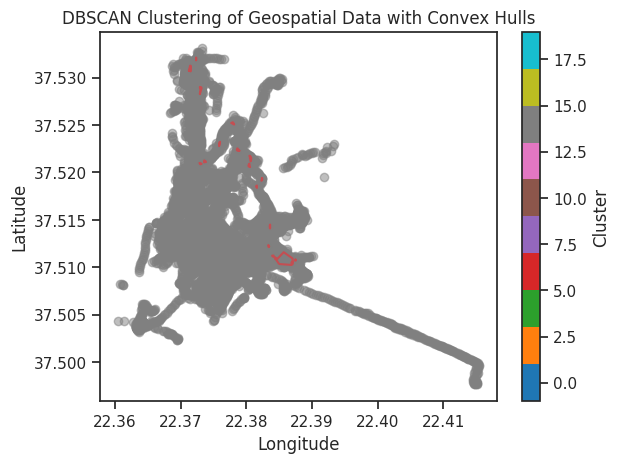

In [12]:
"""
Plots DBSCAN clusters with convex hulls overlaid to highlight the spatial extent of each cluster.

Args:
    df (pd.DataFrame): DataFrame containing clustered data with 'lng', 'lat', and 'cluster' columns.
    clusters (array-like): Array of cluster labels assigned to each point (e.g., from DBSCAN).
    normal_df_points (pd.DataFrame): DataFrame of non-problematic data points to plot in gray for reference.

Functionality:
    - Plots each cluster with a distinct color and labels.
    - Overlays convex hulls around clusters with at least 3 points to show cluster boundaries.
    - Adds non-clustered (normal) points in gray.
    - Adds a colorbar for cluster identification.
    - Saves the resulting figure to `PLOT_FOLDER_PATH`.

Returns:
    None. Displays and saves a clustered map with convex hull overlays.
"""

def plot_convex_hulls(df, clusters, normal_df_points):
    unique_clusters = set(clusters)
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters

    fig, ax = plt.subplots()  # Create figure and axis objects

    # Plot points first for colorbar
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', c=[colors(cluster)], s=10)

    ax.scatter(normal_df_points['lng'], normal_df_points['lat'], c='gray', alpha=0.5)

    # Plot Convex Hulls
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the loop
            ax.plot(cluster_points[hull_points, 0], cluster_points[hull_points, 1], 'r-')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('DBSCAN Clustering of Geospatial Data with Convex Hulls')

    # Create colorbar using scatter points
    cb = fig.colorbar(plt.cm.ScalarMappable(cmap="tab10", norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))),
                      ax=ax, label='Cluster')
    
    # Save the plot
    plot_save_path = os.path.join(PLOT_FOLDER_PATH, "DBSCAN_Clustering_of_Geospatial_Data_with_Convex_Hulls")
    plt.savefig(plot_save_path, bbox_inches='tight')
    plt.show()

plot_convex_hulls(df_danger_cluster, clusters, df[df['isProblem'] == 0])


Get specific **Cluster's BBOX**

In [13]:
"""
Computes the bounding boxes (min/max longitude and latitude) for each DBSCAN cluster.

Args:
    df (pd.DataFrame): DataFrame containing geospatial points with 'lng', 'lat', and 'cluster' columns.
    clusters (array-like): List or array of cluster labels corresponding to each point.

Returns:
    dict: A dictionary where each key is a cluster ID and the value is another dictionary with:
        - 'min_lng': Minimum longitude of the cluster
        - 'max_lng': Maximum longitude of the cluster
        - 'min_lat': Minimum latitude of the cluster
        - 'max_lat': Maximum latitude of the cluster

Notes:
    - Noise points (cluster label -1) are excluded from the results.
    - Useful for visualizing or exporting the spatial extent of each cluster.
"""

def get_bbox_of_clusters(df, clusters):
    cluster_bboxes = {}

    # Iterate over unique clusters (excluding -1 for noise)
    unique_clusters = sorted(set(clusters) - {-1})  # Exclude noise points (-1)

    for cluster in unique_clusters:
        # Filter the points of the current cluster
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']]
        
        # Get the minimum and maximum lng and lat for the bounding box
        min_lng = cluster_points['lng'].min()
        max_lng = cluster_points['lng'].max()
        min_lat = cluster_points['lat'].min()
        max_lat = cluster_points['lat'].max()

        # Store the bounding box for the current cluster
        cluster_bboxes[cluster] = {
            'min_lng': min_lng,
            'max_lng': max_lng,
            'min_lat': min_lat,
            'max_lat': max_lat
        }

    return cluster_bboxes

cluster_bboxes = get_bbox_of_clusters(df_danger_cluster, clusters)

# Display the bounding boxes for each cluster
for cluster, bbox in cluster_bboxes.items():
    print(f"Cluster {cluster}: {bbox}")


Cluster 0: {'min_lng': 22.384585, 'max_lng': 22.3870483, 'min_lat': 37.5102516, 'max_lat': 37.51159}
Cluster 1: {'min_lng': 22.3874233, 'max_lng': 22.3875216, 'min_lat': 37.5106983, 'max_lat': 37.5108166}
Cluster 2: {'min_lng': 22.3868549, 'max_lng': 22.3870566, 'min_lat': 37.5103233, 'max_lat': 37.5105766}
Cluster 3: {'min_lng': 22.3839199, 'max_lng': 22.3841449, 'min_lat': 37.5111466, 'max_lat': 37.5112433}
Cluster 4: {'min_lng': 22.3842799, 'max_lng': 22.3846183, 'min_lat': 37.5108516, 'max_lat': 37.5110883}
Cluster 5: {'min_lng': 22.3833466, 'max_lng': 22.3834666, 'min_lat': 37.5121433, 'max_lat': 37.51235}
Cluster 6: {'min_lng': 22.3835516, 'max_lng': 22.3836183, 'min_lat': 37.5140999, 'max_lat': 37.5145033}
Cluster 7: {'min_lng': 22.3814849, 'max_lng': 22.3816016, 'min_lat': 37.5184116, 'max_lat': 37.5186266}
Cluster 8: {'min_lng': 22.3822883, 'max_lng': 22.3824266, 'min_lat': 37.5191233, 'max_lat': 37.5194066}
Cluster 9: {'min_lng': 22.3803183, 'max_lng': 22.380515, 'min_lat': 3

### Prepare the DF

In [14]:
"""
Extracts relevant columns related to vehicle orientation and identifies the most frequent trip for a specific vehicle.

Steps:
    1. Creates a copy of the merged DataFrame and extracts columns: 
       'vehicleId', 'lat', 'lng', 'dateStoredHuman', 'bearing', 'orientation', 'seconds_diff', and 'trip_id'.
    2. Filters the DataFrame for records with `vehicleId == 1`.
    3. Counts the number of entries per `trip_id` for vehicle 1.
    4. Identifies and prints the `trip_id` that appears most frequently.

Returns:
    None (prints the resulting filtered DataFrame and most frequent trip ID for vehicleId 1).
"""

# *Get specific columns 
_ = merged_dfs.copy()
bearings_df = _[['vehicleId', 'lat', 'lng', 'dateStoredHuman' ,'bearing', 'orientation', 'seconds_diff', 'trip_id']]
print(bearings_df)

# Filter for vehicleId == 1
df_vehicle1 = df[df['vehicleId'] == 1]

# Count occurrences of each trip_id
trip_counts = df_vehicle1['trip_id'].value_counts()

# Get the trip_id with the highest count
most_frequent_trip_id = trip_counts.idxmax()

# Display the result
print(f"The trip_id with the most rows for vehicleId 1 is: {most_frequent_trip_id}")


       vehicleId        lat        lng      dateStoredHuman     bearing  \
0              1  37.510833  22.385710  2024-06-06 17:02:17  137.402376   
1              1  37.510603  22.385977  2024-06-06 17:02:20  312.778670   
2              1  37.510640  22.385927  2024-06-06 17:02:25  351.785725   
3              1  37.510750  22.385907  2024-06-06 17:02:31  307.481149   
4              1  37.510877  22.385698  2024-06-06 17:02:37  318.388767   
...          ...        ...        ...                  ...         ...   
29090         20  37.531460  22.369768  2025-03-06 13:09:13  231.663210   
29091         20  37.531275  22.369473  2025-03-06 13:09:15  235.207818   
29092         20  37.531122  22.369195  2025-03-06 13:09:19  278.389323   
29093         20  37.531148  22.368967  2025-03-06 13:09:21  294.596339   
29094         20  37.531243  22.368705  2025-03-06 13:09:24         NaN   

      orientation  seconds_diff  trip_id  
0       Southeast           0.0        0  
1       North

### Get trip_id's rows

In [15]:
print(df[(df['vehicleId'] == 1) & (df['trip_id'] == most_frequent_trip_id)].head(5))

     vehicleId        lat        lng  velocity      dateStoredHuman  \
946          1  37.510722  22.387033      16.0  2024-06-08 17:32:23   
947          1  37.510692  22.387185       8.0  2024-06-08 17:32:30   
948          1  37.510670  22.387042       9.0  2024-06-08 17:32:38   
949          1  37.510645  22.386773      22.0  2024-06-08 17:32:41   
950          1  37.510685  22.386552      34.0  2024-06-08 17:32:43   

     seconds_diff  trip_id  distance_m     bearing orientation  bearing_diff  \
946           0.0       64        0.00  103.998723        East          0.00   
947           7.0       64       13.82  259.248208        West        155.25   
948           8.0       64       12.90  263.300439        West          4.05   
949           3.0       64       23.88  282.783117        West         19.48   
950           2.0       64       20.10  277.535628        West          5.25   

     velocity_diff  acceleration  isProblem  
946          -40.0      0.000000          0  


## Plot real **directional spread**

### 1️⃣ Violin Plot (Distribution)

Plot saved to ./Plots/


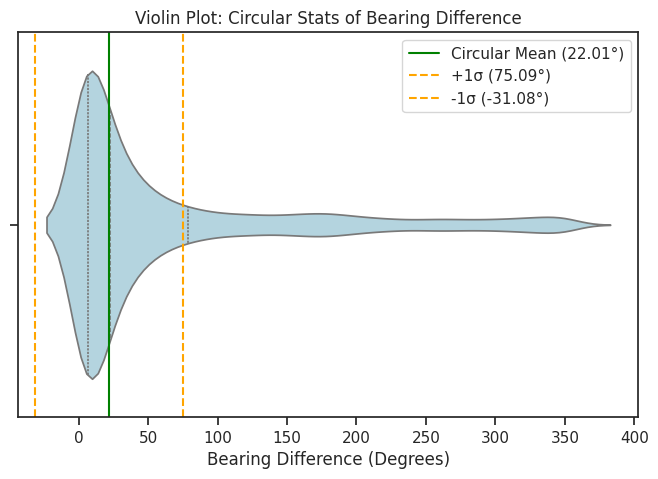

In [16]:
"""
Generates a violin plot to visualize the distribution of bearing differences using circular statistics.

Steps:
    1. Converts the 'bearing_diff' column from degrees to radians for circular statistical analysis.
    2. Computes the circular mean and circular standard deviation in radians, then converts them back to degrees.
    3. Plots a violin plot of 'bearing_diff' to show its distribution.
    4. Overlays vertical lines for:
        - Circular mean (solid green line)
        - ±1 circular standard deviation (dashed orange lines)
    5. Adds labels, legend, and saves the plot to `PLOT_FOLDER_PATH`.

Returns:
    None (displays and saves the plot).
"""

# Convert to radians for circular statistics
bearing_diff_rad = np.deg2rad(merged_dfs['bearing_diff'])

# Compute circular mean and circular standard deviation
circular_mean_rad = circmean(bearing_diff_rad, high=np.pi, low=-np.pi)
circular_std_rad = circstd(bearing_diff_rad, high=np.pi, low=-np.pi)

# Convert back to degrees for plotting
circular_mean_deg = np.rad2deg(circular_mean_rad)
circular_std_deg = np.rad2deg(circular_std_rad)

plt.figure(figsize=(8, 5))

# Create the violin plot
sns.violinplot(x=merged_dfs['bearing_diff'], inner="quartile", color="lightblue")

# Mark the circular mean and circular standard deviation
plt.axvline(x=circular_mean_deg, color='green', linestyle='-', label=f'Circular Mean ({circular_mean_deg:.2f}°)')
plt.axvline(x=circular_mean_deg + circular_std_deg, color='orange', linestyle='--', label=f'+1σ ({(circular_mean_deg + circular_std_deg):.2f}°)')
plt.axvline(x=circular_mean_deg - circular_std_deg, color='orange', linestyle='--', label=f'-1σ ({(circular_mean_deg - circular_std_deg):.2f}°)')

# Labels and title
plt.xlabel('Bearing Difference (Degrees)')
plt.title('Violin Plot: Circular Stats of Bearing Difference')

# Show legend
plt.legend()

# Save and display
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


In [17]:
print((merged_dfs['bearing_diff'] < 0).sum())


0


### 1️⃣ Polar Plot: Bearing Difference Distribution

Polar plot saved to ./Plots/Polar Plot


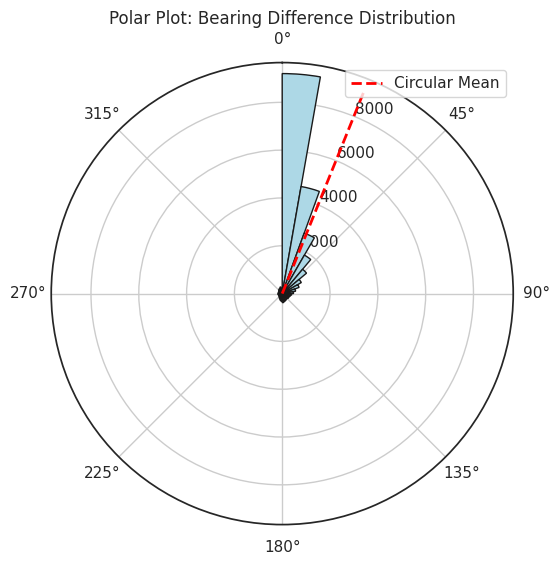

In [18]:
"""
Generates a polar histogram to visualize the distribution of bearing differences as circular data.

Steps:
    1. Converts 'bearing_diff' from degrees to radians and wraps it to [0, 2π] for circular consistency.
    2. Bins the data into `num_bins` angular bins (default is 36 for 10-degree resolution).
    3. Plots a polar bar chart representing frequency of bearing differences across angular bins.
    4. Computes and overlays the circular mean as a red dashed line.
    5. Configures plot orientation (0° at the top, clockwise direction) and adds legend/title.
    6. Saves the plot to `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the polar plot).
"""

# Convert to radians and wrap angles to [0, 2π]
bearing_diff_rad = np.deg2rad(merged_dfs['bearing_diff'] % 360)

# Define number of bins (adjust based on resolution you want)
num_bins = 36  # 10-degree bins

# Create histogram
counts, bin_edges = np.histogram(bearing_diff_rad, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Plot histogram as bars
bars = ax.bar(bin_centers, counts, width=(2 * np.pi / num_bins), bottom=0.0, color='lightblue', edgecolor='k')

circular_mean_rad = circmean(bearing_diff_rad, high=2*np.pi, low=0)
ax.plot([circular_mean_rad, circular_mean_rad], [0, max(counts)], color='red', linestyle='--', linewidth=2, label='Circular Mean')

# Format and show
ax.set_theta_zero_location('N')  # 0° at the top
ax.set_theta_direction(-1)       # Clockwise
plt.title("Polar Plot: Bearing Difference Distribution")
plt.legend(loc='upper right')

# Save and display
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Polar Plot")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Polar plot saved to {plot_save_path}")
plt.show()


###  2️⃣ Boxplot (Detect Outliers)

Boxplot saved to ./Plots/


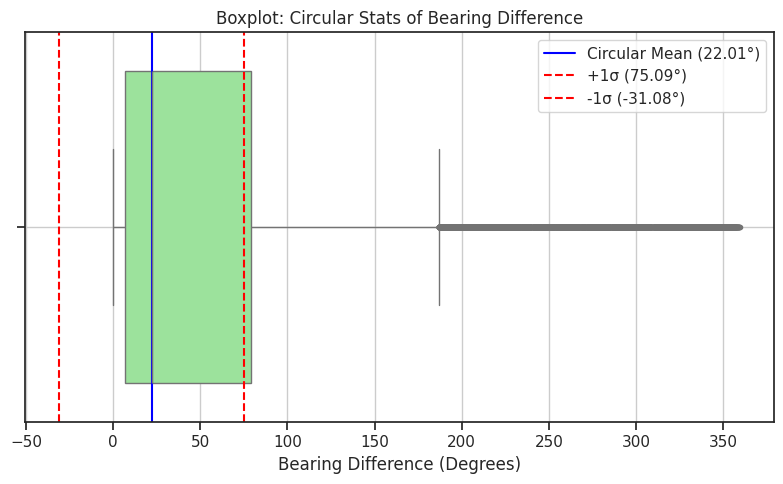

In [19]:
"""
Generates a polar histogram to visualize the distribution of bearing differences as circular data.

Steps:
    1. Converts 'bearing_diff' from degrees to radians and wraps it to [0, 2π] for circular consistency.
    2. Bins the data into `num_bins` angular bins (default is 36 for 10-degree resolution).
    3. Plots a polar bar chart representing frequency of bearing differences across angular bins.
    4. Computes and overlays the circular mean as a red dashed line.
    5. Configures plot orientation (0° at the top, clockwise direction) and adds legend/title.
    6. Saves the plot to `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the polar plot).
"""

# Convert to radians for circular statistics
bearing_diff_rad = np.deg2rad(merged_dfs['bearing_diff'])

# Compute circular mean and circular standard deviation
circular_mean_rad = circmean(bearing_diff_rad, high=np.pi, low=-np.pi)
circular_std_rad = circstd(bearing_diff_rad, high=np.pi, low=-np.pi)

# Convert back to degrees for plotting
circular_mean_deg = np.rad2deg(circular_mean_rad)
circular_std_deg = np.rad2deg(circular_std_rad)

# Create the boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_dfs['bearing_diff'], color='lightgreen', fliersize=3)

# Overlay circular mean and ±1σ
plt.axvline(x=circular_mean_deg, color='blue', linestyle='-', label=f'Circular Mean ({circular_mean_deg:.2f}°)')
plt.axvline(x=circular_mean_deg + circular_std_deg, color='red', linestyle='--', label=f'+1σ ({(circular_mean_deg + circular_std_deg):.2f}°)')
plt.axvline(x=circular_mean_deg - circular_std_deg, color='red', linestyle='--', label=f'-1σ ({(circular_mean_deg - circular_std_deg):.2f}°)')

# Labels and title
plt.xlabel('Bearing Difference (Degrees)')
plt.title('Boxplot: Circular Stats of Bearing Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and display
plot_save_path = PLOT_FOLDER_PATH.replace(".png", "_boxplot.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Boxplot saved to {plot_save_path}")
plt.show()


###  3️⃣ Color by Density

Plot saved to ./Plots/Scatter_bearings_vs_seconds_diff_density.png


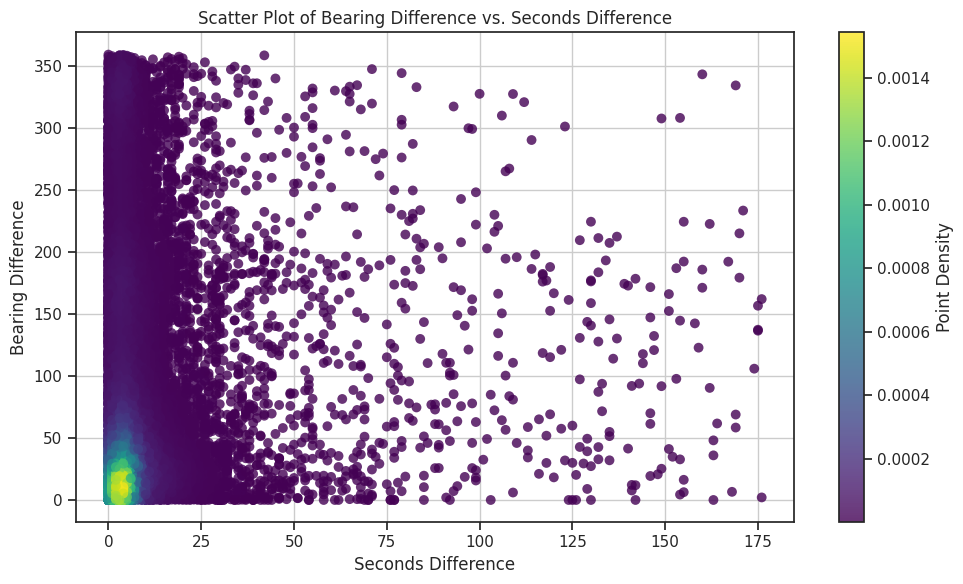

In [20]:
"""
Generates a scatter plot visualizing the relationship between 'bearing_diff' and 'seconds_diff', with point density indicated by color.

Steps:
    1. Extracts the 'seconds_diff' and 'bearing_diff' columns from `merged_dfs`.
    2. Calculates the density of points using `gaussian_kde` for a smoother representation.
    3. Plots a scatter plot where the color of each point represents its density.
    4. Adds a colorbar to indicate the point density.
    5. Configures plot labels, title, and grid for better visualization.
    6. Saves the plot as an image file in the specified `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the scatter plot).
"""

x = merged_dfs['seconds_diff']
y = merged_dfs['bearing_diff']

# Calculate point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=z, cmap='viridis', s=50, edgecolors='none', alpha=0.8)
plt.colorbar(scatter, label='Point Density')
plt.title('Scatter Plot of Bearing Difference vs. Seconds Difference')
plt.xlabel('Seconds Difference')
plt.ylabel('Bearing Difference')
plt.grid(True)
plt.tight_layout()

# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Scatter_bearings_vs_seconds_diff_density.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Plot saved to {plot_save_path}")
plt.show()


###  4️⃣ Scatter + Trend Line + Thresholds

Static plot saved to ./Plots/Enhanced_Scatter_with_LOESS.png


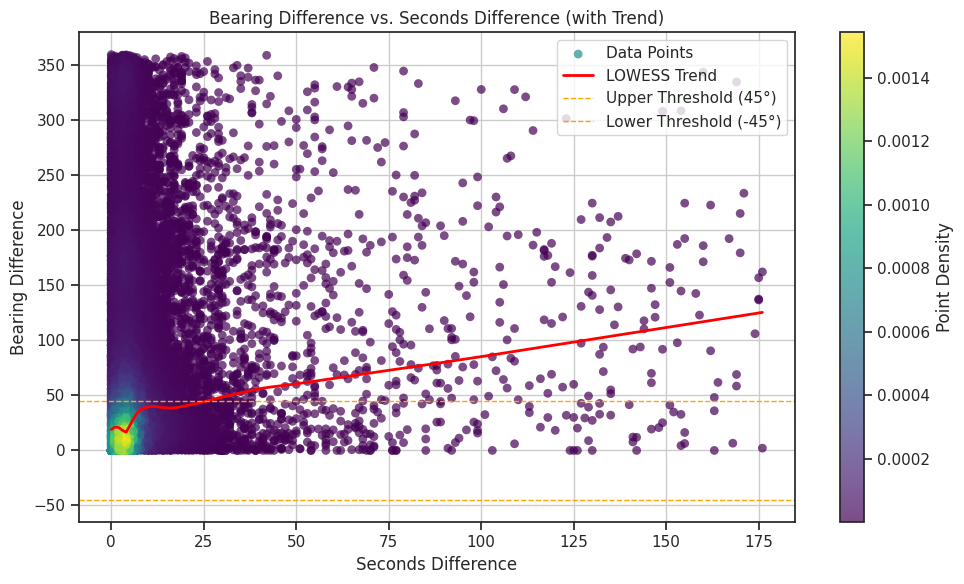

In [21]:
"""
Generates an enhanced scatter plot showing the relationship between 'bearing_diff' and 'seconds_diff',
with density coloring and a LOWESS (Locally Weighted Scatterplot Smoothing) trend line.

Steps:
    1. Extracts the 'seconds_diff' and 'bearing_diff' columns from `merged_dfs`.
    2. Computes the point density using `gaussian_kde` for density-based coloring.
    3. Applies LOWESS smoothing to the 'bearing_diff' values based on 'seconds_diff'.
    4. Plots the scatter plot with density coloring and a LOWESS trend line.
    5. Optionally adds horizontal threshold lines at ±45° to highlight specific ranges.
    6. Configures plot title, labels, color bar, grid, and legend for clarity.
    7. Saves the plot as an image file in the specified `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the enhanced scatter plot).
"""

x = merged_dfs['seconds_diff']
y = merged_dfs['bearing_diff']

# Calculate density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# LOWESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(y, x, frac=0.2)  # Adjust frac for smoothness

plt.figure(figsize=(10, 6))

# Scatter colored by density
scatter = plt.scatter(x, y, c=z, cmap='viridis', s=40, edgecolors='none', alpha=0.7, label='Data Points')

# LOWESS line
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS Trend')

# Optional thresholds (customize as needed)
plt.axhline(y=45, color='orange', linestyle='--', linewidth=1, label='Upper Threshold (45°)')
plt.axhline(y=-45, color='orange', linestyle='--', linewidth=1, label='Lower Threshold (-45°)')

plt.title('Bearing Difference vs. Seconds Difference (with Trend)')
plt.xlabel('Seconds Difference')
plt.ylabel('Bearing Difference')
plt.colorbar(scatter, label='Point Density')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Enhanced_Scatter_with_LOESS.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()


### 5️⃣ KDE Plot for Angular Data

Static plot saved to ./Plots/KDE_of_Bearing_Differences_(Wrapped).png


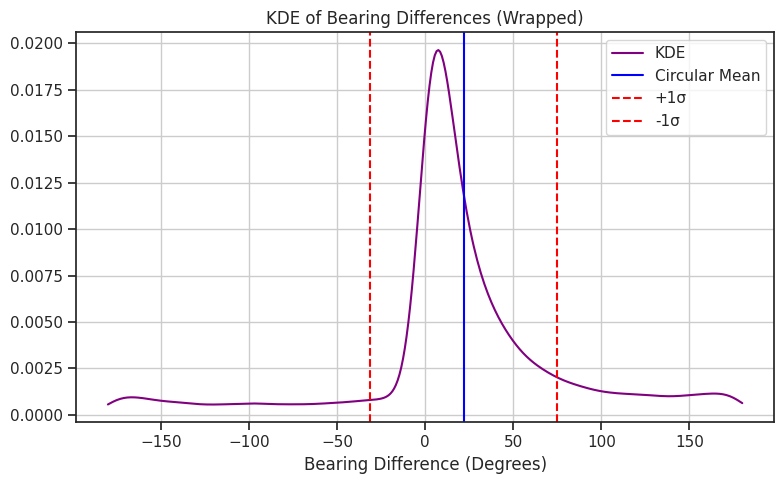

In [22]:
"""
Generates a Kernel Density Estimate (KDE) plot for the wrapped bearing differences.

Steps:
    1. Wraps the 'bearing_diff' angles from the `merged_dfs` DataFrame to be between -180 and 180 degrees.
    2. Performs a KDE estimation to visualize the distribution of wrapped bearing differences.
    3. Plots the KDE curve along with vertical lines indicating the circular mean and ±1 standard deviation.
    4. Adds labels, grid, and a legend for clarity.
    5. Saves the resulting plot as a PNG image in the specified `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the KDE plot).
"""

# Wrap angles between -180 and 180
angles_deg = merged_dfs['bearing_diff']
angles_deg_wrapped = ((angles_deg + 180) % 360) - 180

# KDE estimation
kde = gaussian_kde(angles_deg_wrapped)
x_vals = np.linspace(-180, 180, 360)
kde_vals = kde(x_vals)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, kde_vals, color='purple', label='KDE')
plt.axvline(x=circular_mean_deg, color='blue', linestyle='-', label='Circular Mean')
plt.axvline(x=circular_mean_deg + circular_std_deg, color='red', linestyle='--', label='+1σ')
plt.axvline(x=circular_mean_deg - circular_std_deg, color='red', linestyle='--', label='-1σ')
plt.title("KDE of Bearing Differences (Wrapped)")
plt.xlabel("Bearing Difference (Degrees)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "KDE_of_Bearing_Differences_(Wrapped).png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()


### 6️⃣ Circular Heatmap

Static plot saved to ./Plots/Circular_Heatmap.png


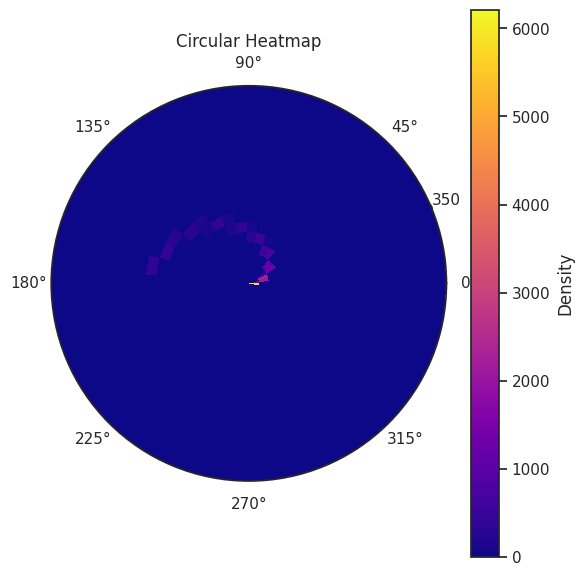

In [23]:
"""
Generates a 2D circular heatmap that visualizes the joint distribution of bearing differences (angles) and their magnitudes.

Steps:
    1. Creates bins for angles (ranging from -π to π) and magnitudes (ranging from 0 to the maximum bearing difference).
    2. Computes the 2D histogram using `np.histogram2d` to capture the density of bearing differences in the defined bins.
    3. Uses a polar plot (`ax.pcolormesh`) to display the heatmap on a circular coordinate system.
    4. Adds a colorbar for reference, and labels the axes for clarity.
    5. Saves the resulting plot as a PNG image in the specified `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the circular heatmap).
"""

# Create 2D histogram: angle + magnitude or time
angle_bins = np.linspace(-np.pi, np.pi, 36)
magnitude_bins = np.linspace(0, merged_dfs['bearing_diff'].max(), 20)

H, _, _ = np.histogram2d(bearing_diff_rad, merged_dfs['bearing_diff'], bins=[angle_bins, magnitude_bins])

theta, r = np.meshgrid(angle_bins[:-1], magnitude_bins[:-1])
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
heatmap = ax.pcolormesh(theta, r, H.T, cmap='plasma')
plt.colorbar(heatmap, label='Density')
ax.set_title("Circular Heatmap")
plt.tight_layout()
# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Circular_Heatmap.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()



### 7️⃣ Combine Plots in a Grid

Static plot saved to ./Plots/Various_Views_of_Bearing_Differences


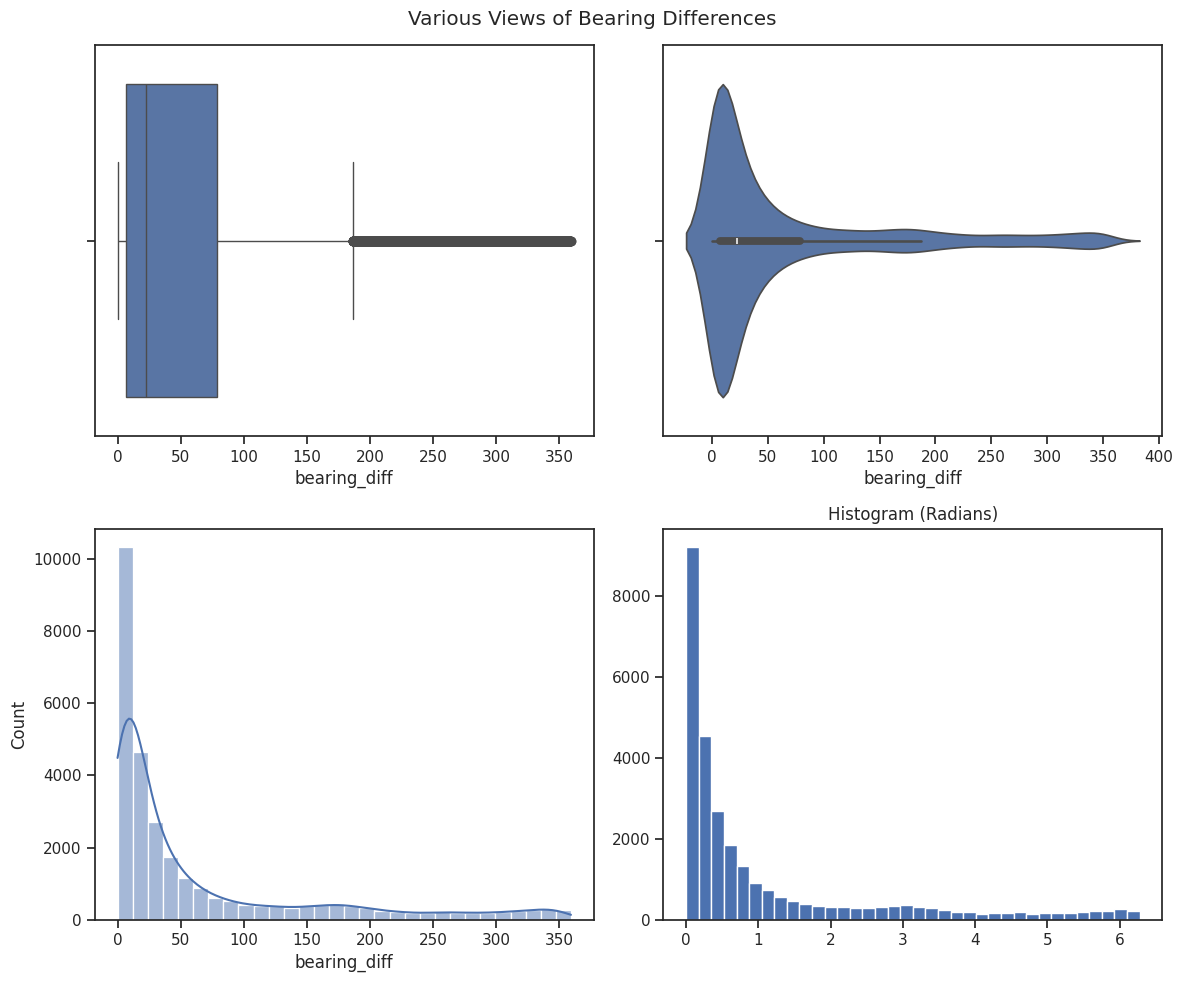

In [24]:
"""
Generates a set of four plots to visualize the distribution of bearing differences.

Steps:
    1. Creates a 2x2 subplot layout with the following visualizations:
        - Top-left: A boxplot of bearing differences.
        - Top-right: A violin plot of bearing differences.
        - Bottom-left: A histogram of bearing differences with a kernel density estimate (KDE).
        - Bottom-right: A histogram of bearing differences in radians.
    2. Adjusts the layout for a clean presentation and sets the main title.
    3. Saves the entire figure as a PNG image in the specified `PLOT_FOLDER_PATH` and displays it.

Returns:
    None (displays and saves the figure containing multiple visualizations of bearing differences).
"""

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x=merged_dfs['bearing_diff'], ax=axs[0, 0])
sns.violinplot(x=merged_dfs['bearing_diff'], ax=axs[0, 1])
sns.histplot(merged_dfs['bearing_diff'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 1].hist(bearing_diff_rad, bins=36)
axs[1, 1].set_title('Histogram (Radians)')

fig.suptitle("Various Views of Bearing Differences")
plt.tight_layout()
# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Various_Views_of_Bearing_Differences")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()


## Plot bearings vs 10 seconds_diff

/tmp/ipykernel_64048/3608393306.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap


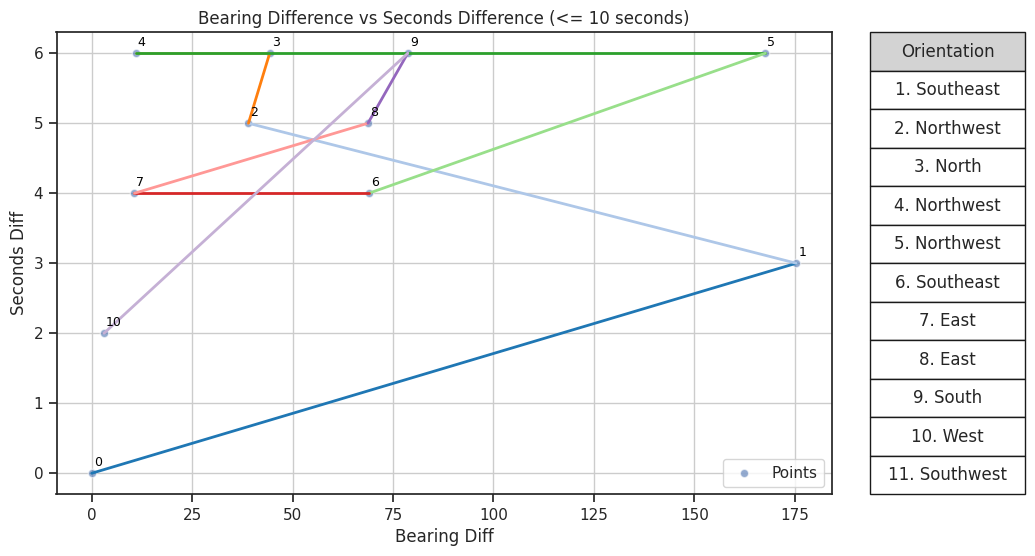

In [25]:
"""
This function filters the DataFrame for specific criteria and generates a scatter plot with segments, labels, and a table.

Steps:
    1. Filters the `merged_dfs` DataFrame to take only the first 20 rows where:
        - `seconds_diff` is less than or equal to 10.
        - `vehicleId` is 1.
        - `trip_id` is 0.
    2. Creates a scatter plot with `bearing_diff` on the x-axis and `seconds_diff` on the y-axis.
    3. Adds colored segments connecting consecutive points with distinct colors.
    4. Labels each point incrementally.
    5. Prepares a table displaying orientation information for each row.
    6. Adds the table to the plot and formats it.
    7. Saves the plot as an image and displays it.

Returns:
    None (displays and saves the plot showing bearing difference vs seconds difference).
"""

# Filter the DataFrame and take only the first 20 rows
filtered_df = merged_dfs[
    (merged_dfs['seconds_diff'] <= 10) & 
    (merged_dfs['vehicleId'] == 1) & 
    (merged_dfs['trip_id'] == 0)
]


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot (swapped axes)
ax.scatter(
    filtered_df['bearing_diff'],
    filtered_df['seconds_diff'],
    alpha=0.6,
    edgecolors='w',
    label='Points'
)

# Generate a list of 20 distinct colors using a colormap
colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap

# Plot segments with changing color for each segment
for i in range(len(filtered_df) - 1):
    # Get the x and y values for the two points
    x_start = filtered_df['bearing_diff'].iloc[i]
    y_start = filtered_df['seconds_diff'].iloc[i]
    x_end = filtered_df['bearing_diff'].iloc[i + 1]
    y_end = filtered_df['seconds_diff'].iloc[i + 1]

    # Assign a unique color for each segment from the 'tab20' colormap
    color = colors(i)  # Get a different color for each segment

    # Plot each segment with its own color
    ax.plot([x_start, x_end], [y_start, y_end], color=color, lw=2)

# Add incremental labels
for i, (x, y) in enumerate(zip(filtered_df['bearing_diff'], filtered_df['seconds_diff'])):
    ax.text(x + 0.5, y + 0.1, str(i), fontsize=9, color='black')

# Prepare the orientation labels
orientation_list = [f"{i+1}. {orientation}" for i, orientation in enumerate(filtered_df['orientation'])]

# Prepare cell text for the table
cell_text = [[orientation] for orientation in orientation_list]

# Add the table on the right side of the plot (without color)
table = ax.table(cellText=cell_text,
                 colLabels=['Orientation'],
                 loc='right',
                 cellLoc='center',
                 colColours=['lightgray'],  # Keep the header background color if desired
                 bbox=[1.05, 0, 0.2, 1])  # Adjust bbox for position and size

# Labels and title
ax.set_title('Bearing Difference vs Seconds Difference (<= 10 seconds)')
ax.set_xlabel('Bearing Diff')
ax.set_ylabel('Seconds Diff')
ax.grid(True)
ax.legend()





plot_save_path = os.path.join(PLOT_FOLDER_PATH, "bearings_vs_seconds_diff.png")
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()


# Trajectory Analysis

#### Filter trips for calculations

In [26]:
"""
This function filters the trips in the dataset based on specific criteria and calculates relevant trip statistics.

Steps:
    1. Group the `merged_dfs` DataFrame by `vehicleId` and `trip_id` to calculate the number of occurrences (i.e., the count of rows for each trip).
    2. Group the `merged_dfs` DataFrame by `vehicleId` and `trip_id` to calculate the total distance traveled for each trip.
    3. Filter the trips that have:
        - More than 10 rows (observations).
        - A total distance traveled greater than 50 meters.
    4. Merge the `valid_trips` DataFrame with the original `merged_dfs` DataFrame to filter out trips that don't meet the criteria.
    5. Print the difference in rows between the original DataFrame and the filtered DataFrame to show how many rows were excluded.

Returns:
    filtered_merged_dfs (DataFrame): A new DataFrame containing only the valid trips with the specified criteria.
"""

trip_counts = merged_dfs.groupby(['vehicleId', 'trip_id']).size().reset_index(name='count')
print(trip_counts)

trip_distances = merged_dfs.groupby(['vehicleId', 'trip_id'])['distance_m'].sum().reset_index(name='total_distance_m')
print(trip_distances)

# *Filter only those trip_ids with more than 10 rows distance traveled > 50
valid_trips = trip_counts[(trip_counts['count'] > 10) & (trip_distances['total_distance_m'] > 50.00)]

filtered_merged_dfs = merged_dfs.copy()
filtered_merged_dfs = pd.merge(merged_dfs, valid_trips[['vehicleId', 'trip_id']], on=['vehicleId', 'trip_id'], how='inner')
print(f"Row difference excluded: {len(merged_dfs)} - {len(filtered_merged_dfs)} = {len(merged_dfs) - len(filtered_merged_dfs)}")



      vehicleId  trip_id  count
0             1        0     13
1             1        1      2
2             1        2      6
3             1        3      4
4             1        4      1
...         ...      ...    ...
1460         20        7      3
1461         20        8     89
1462         20        9     11
1463         20       10      7
1464         20       11     10

[1465 rows x 3 columns]
      vehicleId  trip_id  total_distance_m
0             1        0            291.50
1             1        1              3.88
2             1        2             99.97
3             1        3             44.61
4             1        4              0.00
...         ...      ...               ...
1460         20        7             21.63
1461         20        8           1597.54
1462         20        9            253.65
1463         20       10             40.92
1464         20       11            239.76

[1465 rows x 3 columns]
Row difference excluded: 29095 - 25596 = 3499


### Delete previous random vehicle trips

In [27]:
"""
This function scans through the plot directory and deletes files that match a specific naming pattern.

Steps:
    1. Define a regular expression pattern (`pattern`) to match filenames of the format: "Coordinates_for_Vehicle_<vehicleId>_-_Trip_<tripId>_-_<number>_Data_Points.png".
    2. Iterate through all files in the `PLOT_FOLDER_PATH` directory.
    3. If the filename matches the defined pattern, try to delete the file.
    4. Print the path of the deleted file or an error message if the deletion fails.

Arguments:
    PLOT_FOLDER_PATH (str): The path to the directory containing the plot files to be checked and potentially deleted.
    
Returns:
    None
"""

# Regular expression pattern that matches your generated filenames
pattern = re.compile(r'^Coordinates_for_Vehicle_.*_-_Trip_.*_-_\d+_Data_Points\.png$')

# List all files in the plot directory
for filename in os.listdir(PLOT_FOLDER_PATH):
    if pattern.match(filename):
        file_path = os.path.join(PLOT_FOLDER_PATH, filename)
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")


Deleted: ./Plots/Coordinates_for_Vehicle_9_-_Trip_15_-_50_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_9_-_Trip_489_-_14_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_9_-_Trip_256_-_20_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_7_-_Trip_11_-_113_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_19_-_Trip_0_-_52_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_7_-_Trip_409_-_15_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_7_-_Trip_99_-_312_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_7_-_Trip_85_-_24_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_9_-_Trip_64_-_65_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_9_-_Trip_56_-_81_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_7_-_Trip_469_-_52_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_9_-_Trip_470_-_30_Data_Points.png
Deleted: ./Plots/Coordinates_for_Vehicle_7_-_Trip_186_-_102_Data_Points.png
Deleted: ./Plots/Coordinates_

### Plot random vehicle ids and trip_ids

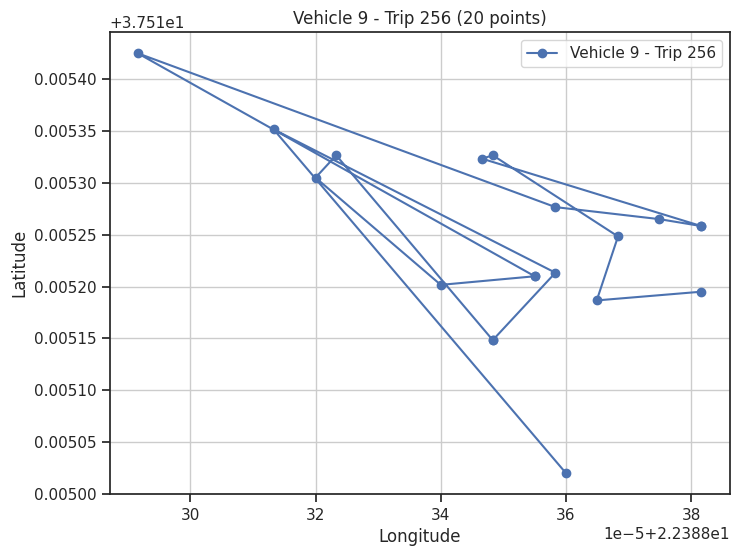

Plot displayed for Vehicle 9 - Trip 256


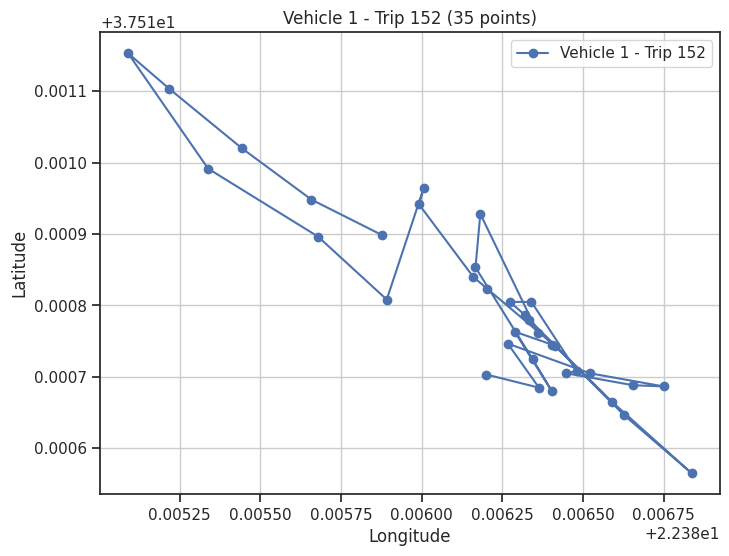

Plot displayed for Vehicle 1 - Trip 152


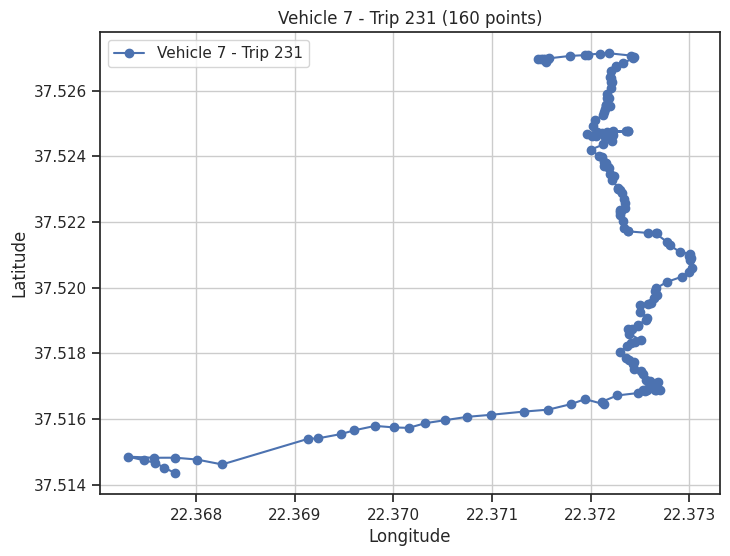

Plot displayed for Vehicle 7 - Trip 231


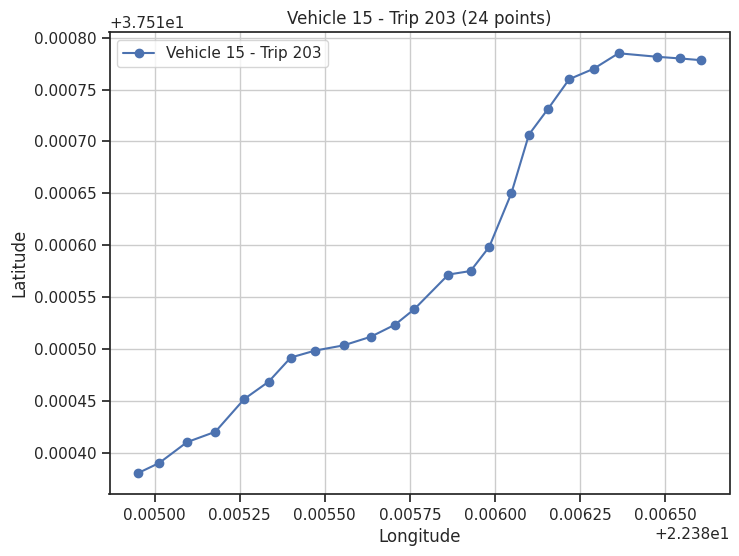

Plot displayed for Vehicle 15 - Trip 203


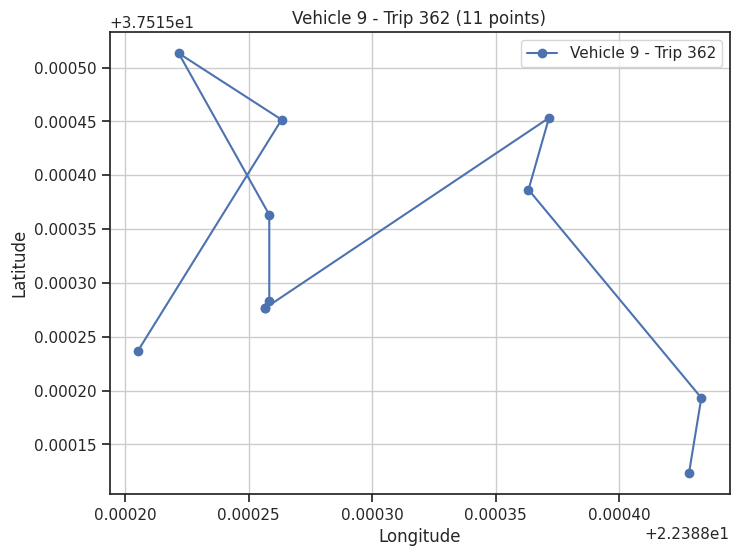

Plot displayed for Vehicle 9 - Trip 362


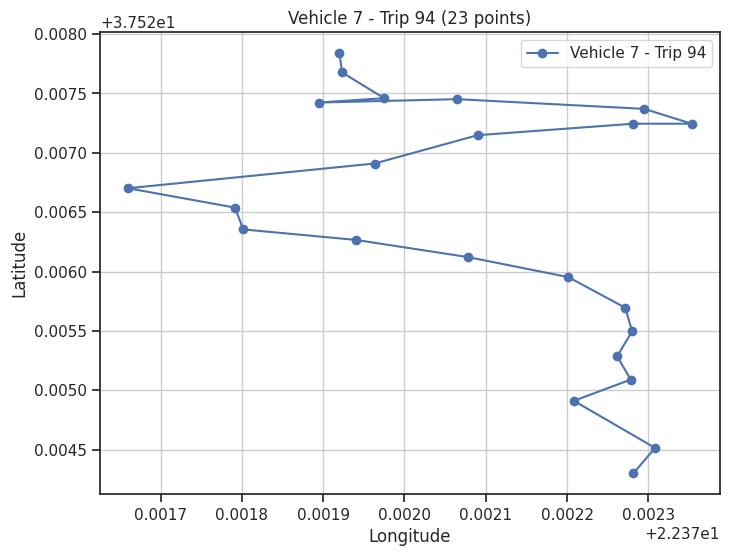

Plot displayed for Vehicle 7 - Trip 94


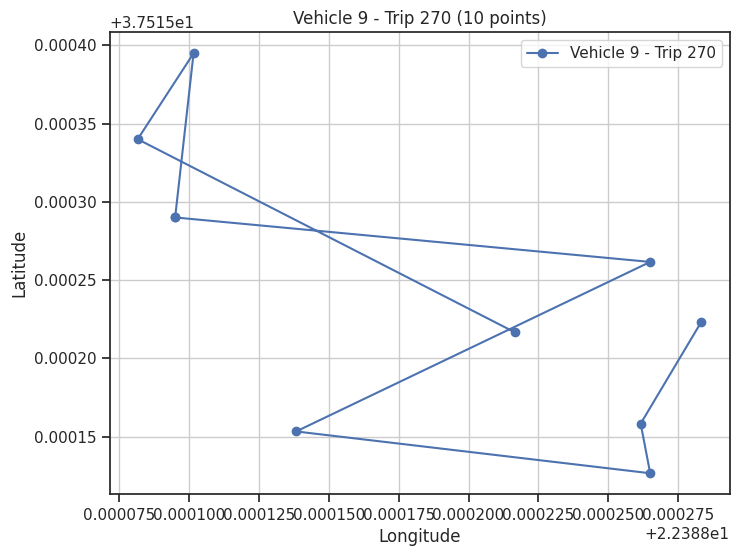

Plot displayed for Vehicle 9 - Trip 270


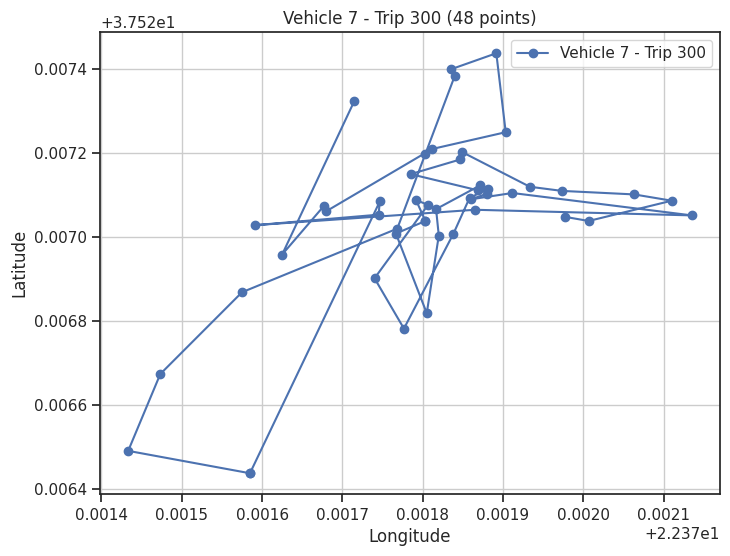

Plot displayed for Vehicle 7 - Trip 300


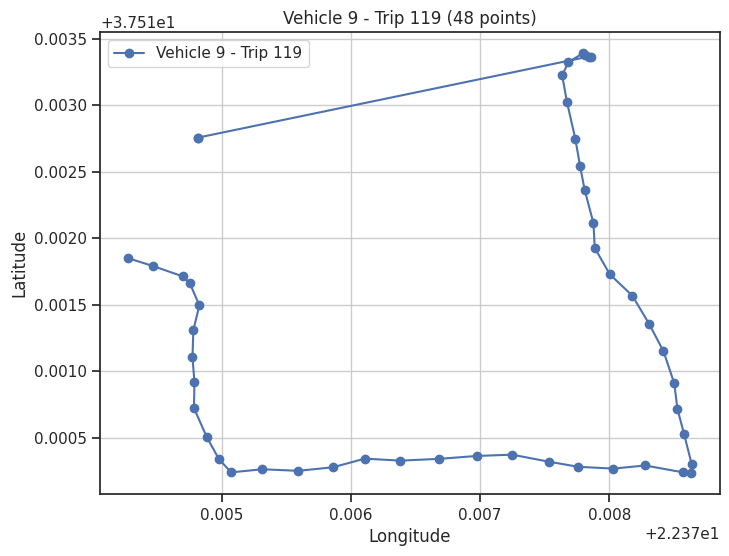

Plot displayed for Vehicle 9 - Trip 119


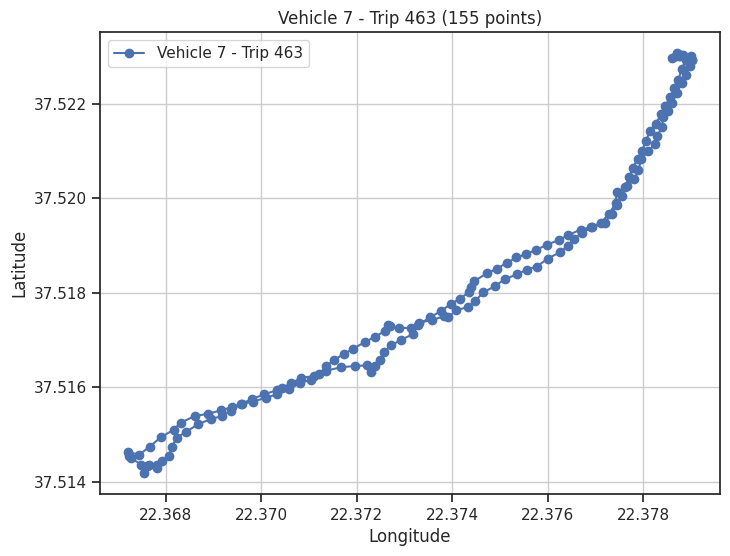

Plot displayed for Vehicle 7 - Trip 463


In [28]:
# === Function to Select a Random Trip ===
def random_ID(df):
    """
    Randomly selects a vehicleId-trip_id pair from the DataFrame where the trip count is >= 10.
    """
    trip_counts = df.groupby(['vehicleId', 'trip_id']).size().reset_index(name='count')
    valid = trip_counts[trip_counts['count'] >= 10]
    if valid.empty:
        return None, None
    sel = valid.sample(1).iloc[0]
    return sel['vehicleId'], sel['trip_id']

# === Loop to Create Plots for 10 Random Trips ===
for i in range(1, 11):
    vehicle_id, trip_id = random_ID(merged_dfs)
    if vehicle_id is None:
        print(f"Iteration {i} - No valid trip found.")
        continue

    # Filter for the chosen trip
    filtered_df = merged_dfs[
        (merged_dfs['vehicleId'] == vehicle_id) &
        (merged_dfs['trip_id']   == trip_id)
    ]
    num_rows = len(filtered_df)

    # --- Plot the Trip ---
    plt.figure(figsize=(8, 6))
    plt.plot(filtered_df['lng'], filtered_df['lat'], marker='o', linestyle='-',
             label=f'Vehicle {vehicle_id} - Trip {trip_id}')
    plt.title(f'Vehicle {vehicle_id} - Trip {trip_id} ({num_rows} points)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)

    # Show the plot (but do not save it)
    plt.show()
    print(f"Plot displayed for Vehicle {vehicle_id} - Trip {trip_id}")


# Save DF to csv

In [29]:
visualize_dangers_path = "./visualize_dangers.csv"
merged_dfs.to_csv(visualize_dangers_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {visualize_dangers_path}" + Style.RESET_ALL)

DataFrame stored to ./visualize_dangers.csv
